# E [$B_x \cdot B_y] $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
from scipy.stats import normaltest, gaussian_kde, probplot
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import time
from tqdm import tqdm

In [2]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

## Constant K, Constant images

In [3]:
num_exp = 100
noise_values = np.logspace(start = -8, stop = 2, num = 100)
summands_lists = [] * len(noise_values)
summands_means = np.zeros(len(noise_values))
B_xs = np.zeros((resolution, resolution, len(noise_values)))

total_sum_df = pd.DataFrame(columns=['Noise', 'Abs_Sum'])
k = np.random.randint(1, resolution + 1, size=2)
# Randomly select image indexes and category indexes
image_indexes = np.random.randint(0, 10, 2)
category_indexes = np.random.randint(0, 10, 2)
# Create image instances
image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)
        

for noise in tqdm(noise_values):
    for i in range(num_exp):
        # Process images
        results = Image.process_images(image1, image2, noise)
        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        sum_left = 0
        sum_right = 0
        # k = np.random.randint(1, resolution + 1, size=2)
        
        # Calculate sum_left and sum_right according to line 44
        for x in range(resolution):
            for y in range(resolution):
                B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                location = np.array([x, y])
                exponent = np.exp(-1j * np.dot(location, k))
                sum_left += exponent * B_x
                exponent = np.exp(1j * np.dot(location, k))
                sum_right += exponent * B_x
        
        # Compute absolute sum
        abs_sum = abs(sum_left * sum_right)
        
        # Append results to DataFrame
        total_sum_df = total_sum_df._append({
            'Noise': noise,
            'Sum_Left': sum_left,
            'Sum_Right': sum_right,
            'alpha_1': alpha_1,
            'alpha_2': alpha_2,
            'k': k,
            'Abs_Sum': abs_sum
        }, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\eriki\AppData\Local\Temp\ipykernel_15416\4279268577.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_sum_df = total_sum_df._append({
100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


In [9]:
# total_sum_df.to_csv('total_sum_df.csv', index=False)

In [4]:
total_sum_df['k_square'] = total_sum_df['k'].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2))
total_sum_df['k_square'] = total_sum_df['k']
total_sum_df.head()

,Noise,Abs_Sum,Sum_Left,Sum_Right,alpha_1,alpha_2,k,k_square
0,1.000000e-08,9.126142e-16,2.394268e-08-1.842179e- 08j,2.394268e-08+1.842179e- 08j,-0.000002,-0.000002,"[4, 24]","[4, 24]"
1,1.000000e-08,1.249831e-15,2.796699e-08-2.162587e- 08j,2.796699e-08+2.162587e- 08j,-0.000002,-0.000002,"[4, 24]","[4, 24]"
2,1.000000e-08,1.139278e-15,2.634412e-08-2.110130e- 08j,2.634412e-08+2.110130e- 08j,-0.000002,-0.000002,"[4, 24]","[4, 24]"
3,1.000000e-08,1.075906e-15,2.561102e-08-2.049346e- 08j,2.561102e-08+2.049346e- 08j,-0.000002,-0.000002,"[4, 24]","[4, 24]"
4,1.000000e-08,8.629372e-16,2.366947e-08-1.739808e- 08j,2.366947e-08+1.739808e- 08j,-0.000002,-0.000001,"[4, 24]","[4, 24]"


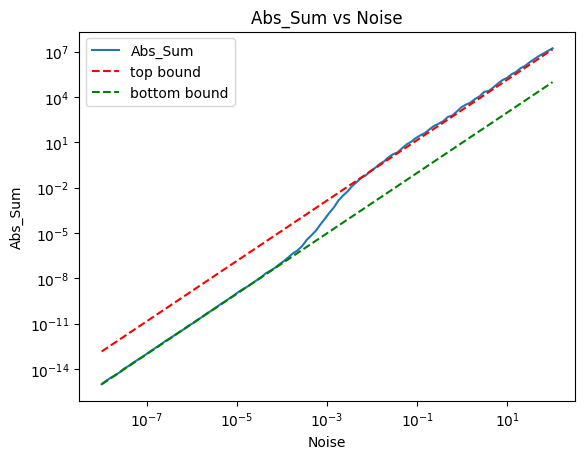

In [10]:
grouped = total_sum_df.groupby('Noise').mean().reset_index()
# grouped = grouped[grouped['Noise'] < 1]

plt.plot(grouped['Noise'], grouped['Abs_Sum'], label='Abs_Sum')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise')
plt.ylabel('Abs_Sum')
plt.title('Abs_Sum vs Noise')

X = np.log(grouped['Noise']).values.reshape(-1, 1)
y = np.log(grouped['Abs_Sum']).values
reg = LinearRegression().fit(X, y)
new_slope = 2
new_intercept = reg.intercept_
new_intercept = np.exp(new_intercept)
plt.plot(grouped['Noise'], new_intercept * grouped['Noise']**new_slope, label='top bound', color='red', linestyle='--')

#new_intercept2 = reg.intercept_ - np.log(2.45 * 1024)

#new_intercept2 = np.exp(new_intercept2)
#plt.plot(grouped['Noise'], new_intercept2 * grouped['Noise']**new_slope, label='bottom bound', color='green', linestyle='--')

new_intercept2 = reg.intercept_ - 5
new_intercept2 = np.exp(new_intercept2)
plt.plot(grouped['Noise'], new_intercept2 * grouped['Noise']**new_slope, label='bottom bound', color='green', linestyle='--')

plt.legend()
plt.show()

Seems like cancelling out the effects of different images really does smooth up the plot, this makes a little more sense than the previous plots where images were randomly sampled for each experiment.

## Changing K, Changing images

In [12]:
num_exp = 400
noise_values = np.logspace(start = -8, stop = 2, num = 100)
summands_lists = [] * len(noise_values)
summands_means = np.zeros(len(noise_values))
B_xs = np.zeros((resolution, resolution, len(noise_values)))

total_sum_df = pd.DataFrame(columns=['Noise', 'Abs_Sum'])
# k = np.random.randint(1, resolution + 1, size=2)

for noise in tqdm(noise_values):
    for i in range(num_exp):
        # Randomly select image indexes and category indexes
        image_indexes = np.random.randint(0, 10, 2)
        category_indexes = np.random.randint(0, 10, 2)
        
        # Create image instances
        image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
        image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)
        
        # Process images
        results = Image.process_images(image1, image2, noise)
        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        sum_left = 0
        sum_right = 0
        k = np.random.randint(1, resolution + 1, size=2)
        
        # Calculate sum_left and sum_right according to line 44
        for x in range(resolution):
            for y in range(resolution):
                B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                location = np.array([x, y])
                exponent = np.exp(-1j * np.dot(location, k))
                sum_left += exponent * B_x
                exponent = np.exp(1j * np.dot(location, k))
                sum_right += exponent * B_x
        
        # Compute absolute sum
        abs_sum = abs(sum_left * sum_right)
        
        # Append results to DataFrame
        total_sum_df = total_sum_df._append({
            'Noise': noise,
            'Sum_Left': sum_left,
            'Sum_Right': sum_right,
            'alpha_1': alpha_1,
            'alpha_2': alpha_2,
            'k': k,
            'Abs_Sum': abs_sum
        }, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_23984\763966950.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_sum_df = total_sum_df._append({
100%|██████████| 100/100 [07:56<00:00,  4.76s/it]


In [13]:
total_sum_df['k_square'] = total_sum_df['k'].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2))
total_sum_df.head()

,Noise,Abs_Sum,Sum_Left,Sum_Right,alpha_1,alpha_2,k,k_square
0,1.000000e-08,3.296273e-18,1.322342e-09-1.244060e- 09j,1.322342e-09+1.244060e- 09j,1.254542e-08,2.322254e-07,"[8, 10]",12.806248
1,1.000000e-08,6.445339e-16,-2.538767e-08-1.772933e- 11j,-2.538767e-08+1.772933e- 11j,-2.503294e-06,-1.898700e-06,"[16, 14]",21.260292
2,1.000000e-08,9.530155e-18,2.769218e-09-1.364399e- 09j,2.769218e-09+1.364399e- 09j,4.803814e-07,-3.439062e-07,"[29, 4]",29.274562
3,1.000000e-08,3.665326e-17,-2.898977e-09+5.314997e- 09j,-2.898977e-09-5.314997e- 09j,3.353727e-07,-3.234711e-07,"[4, 10]",10.770330
4,1.000000e-08,9.068327e-17,9.275868e-09-2.154422e- 09j,9.275868e-09+2.154422e- 09j,-4.491453e-07,-3.104651e-07,"[30, 25]",39.051248


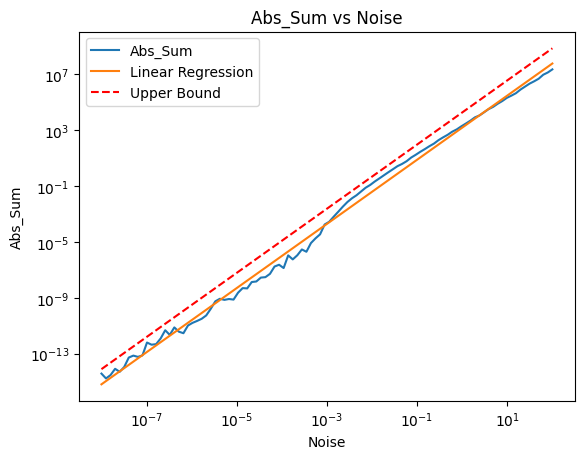

In [22]:
grouped = total_sum_df.groupby('Noise').mean().reset_index()

plt.plot(grouped['Noise'], grouped['Abs_Sum'], label='Abs_Sum')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise')
plt.ylabel('Abs_Sum')
plt.title('Abs_Sum vs Noise')

# Draw a linear line to approximate the curve
X = np.log(grouped['Noise']).values.reshape(-1, 1)
y = np.log(grouped['Abs_Sum']).values
reg = LinearRegression().fit(X, y)
predictions = np.exp(reg.predict(X))
plt.plot(grouped['Noise'], predictions, label='Linear Regression')

#Also add an upper bound
upper_bound_intercept = reg.intercept_ + 2.5
upper_bound_predictions = np.exp(reg.coef_ * X.flatten() + upper_bound_intercept)

plt.plot(grouped['Noise'], upper_bound_predictions, 'r--', label='Upper Bound')


plt.legend()


plt.show()

In [23]:
# Print the coefficients
print('Coefficients: ', reg.coef_)
print('Intercept: ', reg.intercept_)
print('Upper Bound Intercept: ', upper_bound_intercept)

Coefficients:  [2.29424145]
Intercept:  7.312778277858648
Upper Bound Intercept:  9.812778277858648
